In [224]:
import pandas as pd
import pandas as pd

test = pd.read_csv("007_test.csv")
dev = pd.read_csv("007_dev.csv")
train = pd.read_csv("007_train.csv")
df = pd.read_json("008_results_new_new_new.jsonl", lines=True)
labels = [
'happiness', 
'neutral', 
'sadness',
'fear', 
'anger', 
]
from sklearn.metrics import accuracy_score, f1_score
df["accuracy"] = df.apply(lambda row: accuracy_score(row["y_true"],
                                                     row["y_pred"],
                                                     ), axis=1)
df["macroF1"] = df.apply(lambda row: f1_score(row["y_true"],
                                              row["y_pred"], average="macro", labels=labels), axis=1)

# df = df[df.split.str.contains("test")]
# df = df.iloc[[i for i in range(df.shape[0]) if i%3 != 0], :].reset_index(drop=True)
df.model_name_or_path.value_counts()

facebook/wav2vec2-large-slavic-voxpopuli-v2     10
facebook/wav2vec2-large-960h-lv60-self          10
classla/wav2vec2-large-slavic-parlaspeech-hr     8
Name: model_name_or_path, dtype: int64

In [225]:
ids = []
sp_ids = []
for i, row in df.iterrows():
    if "test" in row["split"] :
        ids.append(
            test.utterance_id.tolist()
        )
        sp_ids.append(
            test.speaker_id.tolist()
        )
    else:
        ids.append(
            dev.utterance_id.tolist()
        )
        sp_ids.append(
            dev.speaker_id.tolist()
        )
df["utterance_ids"] = ids
df["speaker_ids"] = sp_ids
for i, row in df.iterrows():
    assert len(row["utterance_ids"]) == len(row["y_pred"])

In [237]:
df.groupby(["model_name_or_path", "split"]).agg(
    {"accuracy": ["mean", "std"],
     "macroF1": ["mean", "std"],
     "y_pred": "count"}
).style.bar(vmin=0.6, subset=[("accuracy", "mean"), ("macroF1", "mean")], cmap="Oranges")

In [227]:
# df[["model_name_or_path", "split", "accuracy", "macroF1"]].set_index(["model_name_or_path", "split"]).sort_index()

In [228]:
gb = df.groupby(["model_name_or_path", "split"]).aggregate({
    "y_pred": [lambda i: len(i.apply(str).value_counts().tolist()),
               lambda i: len(i)]
}).rename(columns={"<lambda_0>": "unique predictions", "<lambda_1>": "num of predictions"})

gb.columns = gb.columns.droplevel(0)


gb.style.apply(lambda row: ['background-color: red']*2 if row[0] != row[1] else [None, None], axis=1)

In [229]:
df.groupby(["split"]).aggregate({
    "y_pred": [lambda i: len(i.apply(str).value_counts().tolist()),
               lambda i: len(i)]
}).rename(columns={"<lambda_0>": "unique predictions", "<lambda_1>": "num of predictions"})

y_pred                   
      unique predictions num of predictions
split                                      
dev                   12                 14
test                  12                 14

In [230]:
def get_per_speaker_error_rate(row):
    speakers = row["speaker_ids"]
    y_true = row["y_true"]
    y_pred = row["y_pred"]
    
    df = pd.DataFrame(data={
        "speaker": speakers,
        "y_true": y_true,
        "y_pred": y_pred
    })
    df["correct"] = df.y_true == df.y_pred
    import numpy as np
    return df.groupby("speaker").aggregate({"correct": "mean"  })

correct_breakdown = []

for i, row in df.iterrows():
    correct_breakdown.append(
        get_per_speaker_error_rate(row).correct.to_json()
    )
df["correct_ratio_breakdown"] = correct_breakdown

    


<AxesSubplot:xlabel='speaker', ylabel='correct_ratio'>

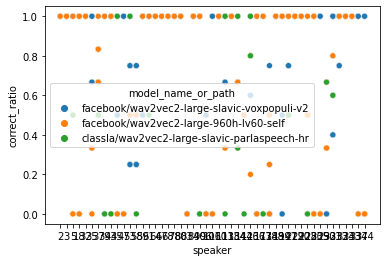

In [231]:
from ast import literal_eval
s = df[df.split == "test"].correct_ratio_breakdown.apply(literal_eval).apply(pd.Series)
# s["model_name_or_path"] = df[df.split=="test"].model_name_or_path.tolist()


        
ndf = s.melt().rename(columns={
    "variable": "speaker",
    "value": "correct_ratio"
})
models = df[df.split=="test"].model_name_or_path.tolist()
new_models = [models[i] for j in range(s.columns.shape[0]) for i in range(s.shape[0])]
ndf["model_name_or_path"] = new_models
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=ndf, x="speaker", y="correct_ratio", hue="model_name_or_path" )

In [232]:
s.columns.shape

(49,)

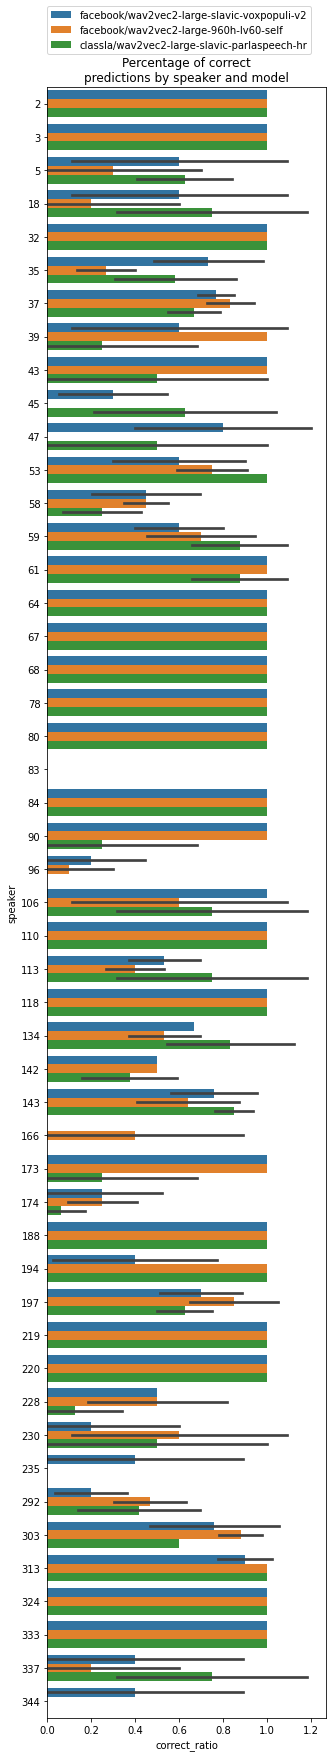

In [243]:
gb = ndf.groupby("speaker").aggregate({
    "correct_ratio": ["mean", "std"]
})
gb.index = gb.index.astype(int)
gb = gb.sort_index()

plt.figure(figsize=(5, 30))
sns.barplot(data = ndf, y = "speaker" , x = "correct_ratio", hue="model_name_or_path", ci="sd")
plt.title("Percentage of correct\npredictions by speaker and model")
plt.legend(loc=(0, 1.02))
plt.xlim((0, None))
# plt.tight_layout()
plt.savefig("images/008_speaker_and_model_correctness.pdf", dpi=200)
plt.show()

In [234]:
test_speakers = set(test.speaker_id.tolist())
dev_speakers = set(dev.speaker_id.tolist())
train_speakers = set(train.speaker_id.tolist())

In [235]:
d = {"test_speakers": test_speakers,
     "dev_speakers": dev_speakers, 
     "train_speakers": train_speakers}

for first in d:
    for second in d:
        if first == second:
            continue
        print(f"{first} against {second}: {len(d[first].intersection(d[second]))} leaked")

test_speakers against dev_speakers: 0 leaked
test_speakers against train_speakers: 0 leaked
dev_speakers against test_speakers: 0 leaked
dev_speakers against train_speakers: 0 leaked
train_speakers against test_speakers: 0 leaked
train_speakers against dev_speakers: 0 leaked
